In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings

In [2]:
warnings.filterwarnings("ignore")

data = yf.download("TSLA", start="2015-01-01", end="2025-01-01", progress=False)
data = data[['Close']]
data.fillna(method='ffill', inplace=True)

YF.download() has changed argument auto_adjust default to True


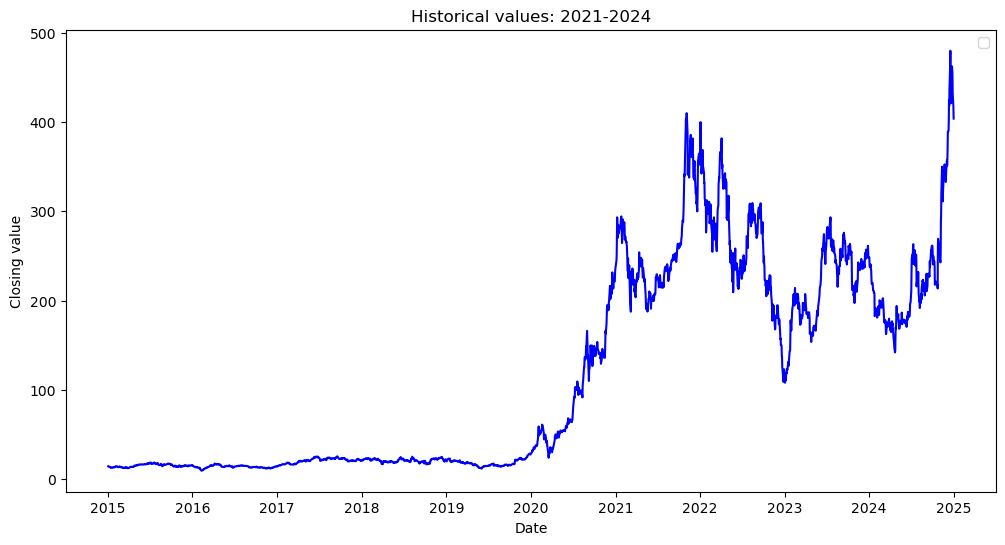

In [3]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'], color = "blue")
plt.xlabel("Date")
plt.ylabel("Closing value")
plt.title("Historical values: 2021-2024")
plt.legend()
plt.show()

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_size = int(len(data['Close'])*0.7)
val_size = int(len(data['Close'])*0.15)
test_size = len(data['Close']) - train_size - val_size

train_data = data[['Close']][:train_size]
val_data = data[['Close']][train_size:train_size+val_size]
test_data = data[['Close']][train_size+val_size:]

scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_data)

# Avoid leakage by using the scaling parameters of the training set

val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

print(train_data.index)
print(val_data.index)
print(test_data.index)

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2021-12-15', '2021-12-16', '2021-12-17', '2021-12-20',
               '2021-12-21', '2021-12-22', '2021-12-23', '2021-12-27',
               '2021-12-28', '2021-12-29'],
              dtype='datetime64[ns]', name='Date', length=1761, freq=None)
DatetimeIndex(['2021-12-30', '2021-12-31', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-10',
               '2022-01-11', '2022-01-12',
               ...
               '2023-06-16', '2023-06-20', '2023-06-21', '2023-06-22',
               '2023-06-23', '2023-06-26', '2023-06-27', '2023-06-28',
               '2023-06-29', '2023-06-30'],
              dtype='datetime64[ns]', name='Date', length=377, freq=None)
DatetimeIndex(['2023-07-03', '2023-07-05', '2023-07-06', '2023-07-07',


In [5]:
def create_sequences(data, seq_length):

    Sequences = []
    targets = []

    for i in range(len(data)-seq_length):

        Sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])

    return np.array(Sequences), np.array(targets)

sequences_length = 120

X_train, y_train = create_sequences(train_scaled,sequences_length)
X_val, y_val = create_sequences(val_scaled,sequences_length)
X_test, y_test = create_sequences(test_scaled,sequences_length)

In [6]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, GRU, Dropout, Dense, Flatten

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7,
                               restore_best_weights=True)
p = 0.3 # controls dropout
epochs = 100
batch_size = 32
rate = 0.0008
optimizer_lstm = Adam(learning_rate=rate)
optimizer_gru = Adam(learning_rate=rate)
optimizer_cnn_lstm = Adam(learning_rate=rate)

In [8]:
# LSTM

warnings.filterwarnings("ignore")
units = 100 # LSTM, GRU
d = 25 # Dense

model_lstm = Sequential([
    LSTM(units, return_sequences=True, input_shape = (sequences_length,1)),
    Dropout(p),
    LSTM(units, return_sequences=False),
    Dropout(p),
    Dense(d, activation='relu'),
    Dense(1)
])

model_lstm.compile(optimizer=optimizer_lstm, loss="mean_squared_error")

model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 120, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,751 (483.40 KB)

 Trainable params: 123,751 (483.40 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# GRU

warnings.filterwarnings("ignore")
#units = 100

model_gru = Sequential([
    GRU(units, return_sequences=True, input_shape = (sequences_length,1)),
    Dropout(p),
    GRU(units, return_sequences=False),
    Dropout(p),
    Dense(d, activation='relu'),
    Dense(1)
])

model_gru.compile(optimizer=optimizer_gru, loss="mean_squared_error")

model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 120, 100)       │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 120, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,051 (367.39 KB)

 Trainable params: 94,051 (367.39 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model_cnn_lstm = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequences_length, 1)),  
    MaxPooling1D(pool_size=2),  
    LSTM(units, return_sequences=True),
    Dropout(p),
    LSTM(units, return_sequences=False),
    Dropout(p),
    Dense(d, activation='relu'),
    Dense(1)
])

model_cnn_lstm.summary()

model_cnn_lstm.compile(optimizer=optimizer_cnn_lstm, loss="mean_squared_error")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 118, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 59, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 59, 100)        │        53,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 59, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,279 (532.34 KB)

 Trainable params: 136,279 (532.34 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Training LSTM

history_lstm = model_lstm.fit(
    X_train, y_train, validation_data=(X_val,y_val),
    epochs=epochs, batch_size=batch_size, callbacks = [early_stopping]
)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0305 - val_loss: 0.0033
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0017 - val_loss: 0.0040
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0018 - val_loss: 0.0057
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 8.6673e-04 - val_loss: 0.0034
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 9.5625e-04 - val_loss: 0.0017
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 8.5200e-04 - val_loss: 0.0017
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━

In [12]:
# Training GRU

history_gru = model_gru.fit(
    X_train, y_train, validation_data=(X_val,y_val),
    epochs=epochs, batch_size=batch_size, callbacks = [early_stopping]
)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 0.0269 - val_loss: 0.0013
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 0.0012 - val_loss: 8.9083e-04
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 8.4984e-04 - val_loss: 8.9642e-04
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - loss: 9.5534e-04 - val_loss: 0.0010
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - loss: 9.3240e-04 - val_loss: 8.6075e-04
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - loss: 7.4618e-04 - val_loss: 8.4971e-04
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - loss: 7.0507e-04 - val_loss: 0.0020
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 8.0347e-04 - val_loss: 0.0036
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - loss: 7.4464e-04 - val_loss: 0.0

In [ ]:
# Trainning CNN-LSTM

history_cnn_lstm = model_cnn_lstm.fit(
    X_train, y_train, validation_data=(X_val,y_val),
    epochs=(epochs), batch_size=batch_size, callbacks = [early_stopping]
)

Epoch 1/150


NotImplementedError: numpy() is only available when eager execution is enabled.

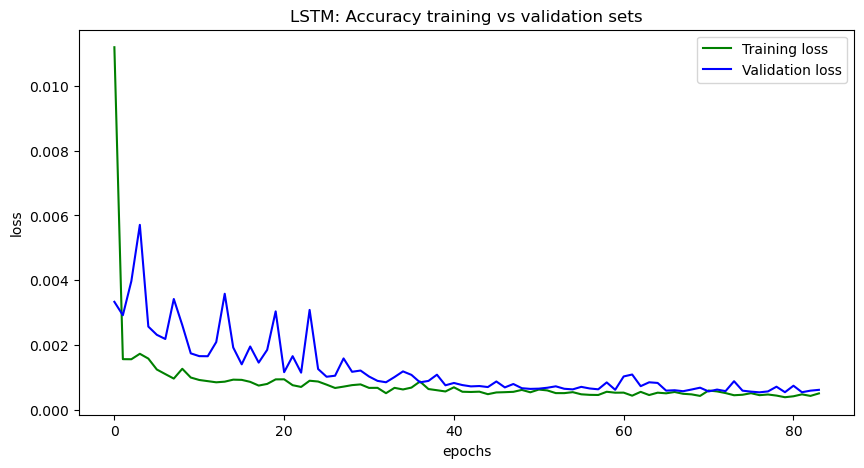

In [14]:
plt.figure(figsize=(10,5))
plt.plot(history_lstm.history['loss'], color="green", label = "Training loss")
plt.plot(history_lstm.history['val_loss'], color="blue", label = "Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("LSTM: Accuracy training vs validation sets")
plt.legend()
plt.show()

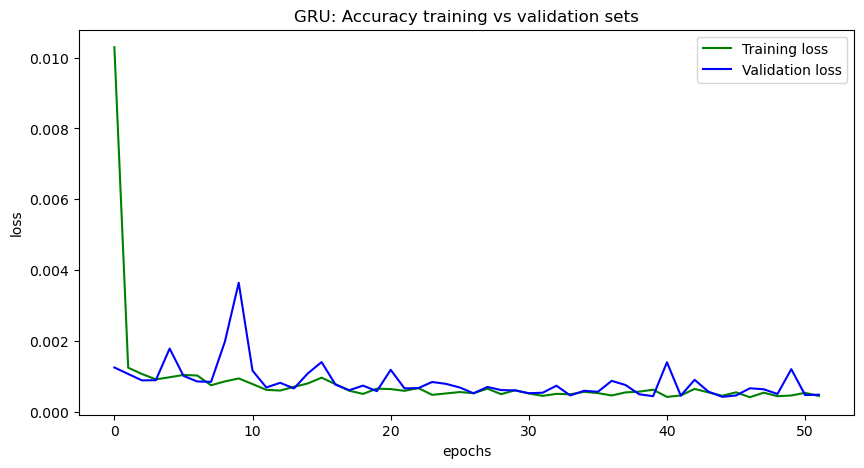

In [15]:
plt.figure(figsize=(10,5))
plt.plot(history_gru.history['loss'], color="green", label = "Training loss")
plt.plot(history_gru.history['val_loss'], color="blue", label = "Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("GRU: Accuracy training vs validation sets")
plt.legend()
plt.show()

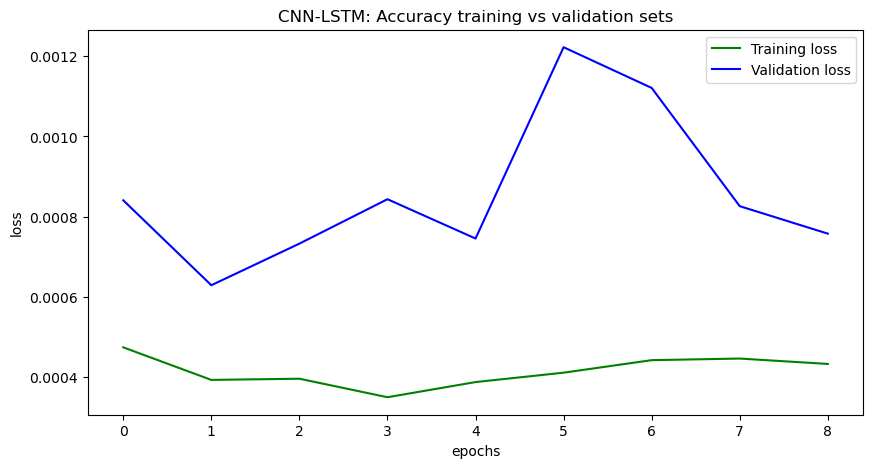

In [20]:
plt.figure(figsize=(10,5))
plt.plot(history_cnn_lstm.history['loss'], color="green", label = "Training loss")
plt.plot(history_cnn_lstm.history['val_loss'], color="blue", label = "Validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("CNN-LSTM: Accuracy training vs validation sets")
plt.legend()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


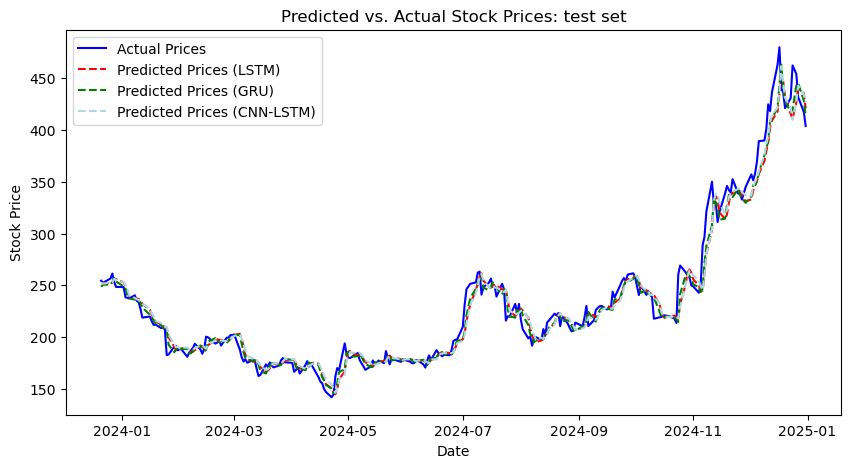

In [17]:
# Predictions
y_pred_lstm = model_lstm.predict(X_test)
y_pred_gru = model_gru.predict(X_test)
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test)
test_dates = data.index[train_size + val_size + sequences_length:]

# Inverse transform predictions & actuals
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_pred_gru = scaler.inverse_transform(y_pred_gru.reshape(-1, 1))
y_pred_cnn_lstm = scaler.inverse_transform(y_pred_cnn_lstm.reshape(-1, 1))


# Plots

plt.figure(figsize=(10, 5))
plt.plot(test_dates, y_test_rescaled, label="Actual Prices", color="blue")
plt.plot(test_dates, y_pred_lstm, label="Predicted Prices (LSTM)", color="red", linestyle="dashed")
plt.plot(test_dates, y_pred_gru, label="Predicted Prices (GRU)", color="green", linestyle="dashed")
plt.plot(test_dates, y_pred_cnn_lstm, label="Predicted Prices (CNN-LSTM)", color="lightblue", linestyle="dashed")
plt.legend()
plt.title("Predicted vs. Actual Stock Prices: test set")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_lstm = mean_squared_error(y_test_rescaled, y_pred_lstm, squared=False)
rmse_gru = mean_squared_error(y_test_rescaled, y_pred_gru, squared=False)
rmse_cnn_lstm = mean_squared_error(y_test_rescaled, y_pred_cnn_lstm, squared=False)

mae_lstm = mean_absolute_error(y_test_rescaled, y_pred_lstm)
mae_gru = mean_absolute_error(y_test_rescaled, y_pred_gru)
mae_cnn_lstm = mean_absolute_error(y_test_rescaled, y_pred_cnn_lstm)

print(f"RMSE (LSTM): {rmse_lstm:.4f}")
print(f"RMSE (GRU): {rmse_gru:.4f}")
print(f"RMSE (CNN-LSTM): {rmse_cnn_lstm:.4f}")
print(f"MAE (LSTM): {mae_lstm:.4f}")
print(f"MAE (GRU): {mae_gru:.4f}")
print(f"MAE (CNN-LSTM): {mae_cnn_lstm:.4f}")


RMSE (LSTM): 12.9087
RMSE (GRU): 11.2574
RMSE (CNN-LSTM): 12.8635
MAE (LSTM): 8.6820
MAE (GRU): 7.4408
MAE (CNN-LSTM): 8.8021
